# Import libraries

In [1]:
!git clone https://github.com/mcordts/cityscapesScripts.git

Cloning into 'cityscapesScripts'...
remote: Enumerating objects: 674, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 674 (delta 195), reused 184 (delta 163), pack-reused 427 (from 1)
Receiving objects: 100% (674/674), 837.07 KiB | 17.08 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
# import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
import torchvision.transforms.v2 as T

from cityscapesScripts.cityscapesscripts.helpers.labels import id2label, trainId2label, labels, name2label

# Helper functions

In [4]:
class_id_to_name = {}
class_id_to_color = {}
colors = []
for l in labels:
    if l[2] != 255:
        class_id_to_name[l[2]+1] = l[0]
        class_id_to_color[l[2]+1] = l[-1]
        colors.append(l[-1])
    else:
        class_id_to_name[0] = l[0]
        class_id_to_color[0] = l[-1]
        colors.insert(0, l[-1])

def convert_instance_to_semantic(instance_masks, instance_labels):
    """
    Converts an instance mask of shape [N, H, W] to a semantic mask of shape [H, W].
    
    This is done by "painting" the class ID from instance_labels onto the
    corresponding binary mask from instance_masks.
    """
    if instance_masks.ndim != 3 or instance_labels.ndim != 1:
        raise ValueError(f"Expected shapes [N, H, W] and [N], but got "
                         f"{instance_masks.shape} and {instance_labels.shape}")
    
    # Reshape labels to [N, 1, 1] to allow broadcasting
    reshaped_labels = instance_labels.view(-1, 1, 1)
    
    # Multiply masks by their labels and take the max to handle overlaps
    # The result is a single [H, W] tensor where each pixel has the class ID
    semantic_mask = torch.max(instance_masks.float() * reshaped_labels, dim=0)[0]
    
    return semantic_mask.long()

def convert_instance_to_semantic_strict(instance_masks: torch.Tensor, instance_labels: torch.Tensor,
                                 image_size: tuple = (512, 1024), num_classes: int = 20, ignore_index: int = 255,
                                 background_class_id: int = 0) -> torch.Tensor:
    """
    Converts instance masks and labels to a single semantic segmentation map.
    Handles cases where no instances are found.

    Args:
        instance_masks (torch.Tensor): Tensor of instance masks, shape [N, 1, H, W] or [N, H, W].
        instance_labels (torch.Tensor): Tensor of instance labels, shape [N].
        image_size (tuple): (H, W) of the original image.
        num_classes (int): Total number of semantic classes (used for sanity, not direct output).
                           Note: Your Cityscapes labels might include 0 as a valid class.
                           Ensure background_class_id aligns with your dataset's conventions.
        background_class_id (int): The class ID to use for background/no detections.
                                   This should typically be a valid class ID, often 0.

    Returns:
        torch.Tensor: Semantic segmentation map, shape [H, W], with class IDs.
                      The class IDs will be in range [0, num_classes-1] (or background_class_id).
    """
    H, W = image_size
    # Initialize with the background class ID. This is crucial when no instances are found.
    semantic_map = torch.full((H, W), fill_value=background_class_id, dtype=torch.long, device=instance_masks.device)

    if instance_masks.shape[0] == 0: # No instances detected
        return semantic_map

    # Ensure masks are [N, H, W]
    if instance_masks.dim() == 4 and instance_masks.shape[1] == 1:
        instance_masks = instance_masks.squeeze(1) # [N, 1, H, W] -> [N, H, W]
    elif instance_masks.dim() != 3: # [N, H, W]
        raise ValueError(f"Expected instance_masks to be [N, 1, H, W] or [N, H, W]. Got {instance_masks.shape}")

    # If instance_masks and instance_labels are sorted by confidence, processing from highest confidence first
    # would make sense for overlapping regions if you want the highest confidence object to "win".
    for mask, label in zip(instance_masks, instance_labels):
        # Assuming model outputs probabilities/logits for masks, thresholding is needed.
        if label.item() != ignore_index: 
             semantic_map[mask > 0.5] = label.item()

    return semantic_map


def colorize_mask(mask, color_dict):
    """Converts a HxW segmentation mask of class indices to a 3xHxW RGB image."""
    # Ensure mask is on CPU and is a numpy array
    mask_np = mask.cpu().numpy()
    rgb_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    
    present_classes = np.unique(mask_np)
    
    for class_id in present_classes:
        if class_id in color_dict:
            indices = (mask_np == class_id)
            # Assign the corresponding color
            rgb_mask[indices] = color_dict[class_id]
            
    return torch.from_numpy(rgb_mask).permute(2, 0, 1)

# Config

In [5]:
from omegaconf import OmegaConf

def load_config(filepath):
    with open(filepath, 'r') as f:
        return OmegaConf.load(f)
    

path_cfg = load_config("/kaggle/input/segment-city/path_config.yaml")
train_cfg = load_config("/kaggle/input/segment-city/train_config.yaml")
model_cfg = load_config("/kaggle/input/segment-city/model_config.yaml")

In [6]:
path_cfg.dataset_path = "/kaggle/input/cityscapes"
config = OmegaConf.merge(path_cfg, train_cfg, model_cfg)

config.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model

## UNet

In [7]:
import torch
import torch.nn as nn
from torch.utils.checkpoint import checkpoint

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, X):
        return self.double_conv(X)

class DownLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, X):
        return self.maxpool_conv(X)

class UpLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, X, C):
        X = self.up(X)
        diffY = C.size()[2] - X.size()[2]
        diffX = C.size()[3] - X.size()[3]

        X = nn.functional.pad(X, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        X = torch.cat([C, X], dim = 1)
        return self.conv(X)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, n_channels, n_classes) -> None:
        super(UNET, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inp = DoubleConv(n_channels, 64)
        self.down1 = DownLayer(64, 128)
        self.down2 = DownLayer(128, 256)
        self.down3 = DownLayer(256, 512)
        self.down4 = DownLayer(512, 1024)

        self.up1 = UpLayer(1024, 512)
        self.up2 = UpLayer(512, 256)
        self.up3 = UpLayer(256, 128)
        self.up4 = UpLayer(128, 64)
        self.out = OutConv(64, n_classes)

    def contracting_path(self, X):
        out1 = self.down1(X) # 128 x 280 x 280
        out2 = self.down2(out1) # 256 x 136 x 136
        out3 = self.down3(out2) # 512 x 64 x 64
        out4 = self.down4(out3) # 1024 x 28 x 28
        return out1, out2, out3, out4
    
    def expansive_path(self, c4, c3, c2, c1, c0):
        out = self.up1(c4, c3) # 512 x 52 x 52
        out = self.up2(out, c2) # 256 x 100 x 100
        out = self.up3(out, c1) # 128 x 196 x 196
        out = self.up4(out, c0) # 64 x 388 x 388
        return out
    
    def forward(self, X):
        c0 = self.inp(X) # 64 x 568 x 568
        c1, c2, c3, c4 = self.contracting_path(c0)
        e = self.expansive_path(c4, c3, c2, c1, c0)
        logits = self.out(e) # 2 x 388 x 388
        return logits

## MaskRCNN

In [8]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

def build_MaskRCNN(num_classes):
    weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    maskrcnn = maskrcnn_resnet50_fpn_v2(weights)
    
    in_features_box = maskrcnn.roi_heads.box_predictor.cls_score.in_features
    in_features_mask = maskrcnn.roi_heads.mask_predictor.conv5_mask.in_channels
    
    dim_reduced = maskrcnn.roi_heads.mask_predictor.conv5_mask.out_channels
    
    maskrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=num_classes)
    maskrcnn.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=num_classes)
    return maskrcnn

## Get model function

In [9]:
def build_model(model_config, num_channels=3, num_classes=20):
    if model_config.model_name.lower() == "unet":
        return UNET(num_channels, num_classes)
    elif model_config.model_name.lower() == "maskrcnn":
        return build_MaskRCNN(num_classes)
    else:
        print(f"{model_config.model_name} is currently not supported")

# Custom dataset

In [ ]:
id_to_trainId_map = torch.zeros((34,), dtype=torch.long)
for label in labels:
    if -1 <= label.id <= 33: # Handle all valid IDs
        # Use positive indices for the map, handle -1 case in the function
        if label.id >= 0:
            id_to_trainId_map[label.id] = label.trainId + 1
            if label.trainId == 255:
                id_to_trainId_map[label.id] = 0
    
class CityscapesDataset(Dataset):
    def __init__(self, config, transform=None, split='train'):
        super().__init__()
        self.images = [] # path to leftImg8bit
        self.label_images = [] # path to labels images
        self.config = config
        self._transform = transform
        
        self.class_names = [label.category for label in labels]

        left8bit_path = os.path.join(self.config.dataset_path, "leftImg8bit", split)
        for city in os.listdir(left8bit_path):
            city_images = list(os.listdir(os.path.join(left8bit_path, city)))
            city_images = [os.path.join(left8bit_path, city, image) for image in city_images]
            self.images.extend(city_images)
            
        for city in os.listdir(os.path.join(self.config.dataset_path, self.config.type, split)):
            city_dir = os.path.join(self.config.dataset_path, self.config.type, split, city)
            for file in os.listdir(city_dir):
                if file.endswith("labelIds.png"):
                    self.label_images.append(os.path.join(city_dir, file))

        self.images = sorted(self.images)
        self.label_images = sorted(self.label_images)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = read_image(str(self.images[idx]))

        img, target = self._get_semantic_item(idx, img)
        
        if self._transform:
            img, target = self._transform(img, target)
            
        return img, target

    def _get_semantic_item(self, idx, img):
        mask = read_image(str(self.label_images[idx])).long() # Shape: [1, H, W]

        converted_mask = torch.full_like(mask, 0) 
        converted_mask[mask == -1] = 0
        valid_pixels = (mask >= 0) & (mask <= 33)
        converted_mask[valid_pixels] = id_to_trainId_map[mask[valid_pixels]]
        # print(converted_mask.shape)

        obj_ids = torch.unique(converted_mask).to(dtype=torch.uint8)
        # print(obj_ids)
        converted_mask = (converted_mask == obj_ids[:, None, None]).to(dtype=torch.long)
        # print(converted_mask.shape)
        boxes = masks_to_boxes(converted_mask)
        labels = obj_ids[:, None].to(dtype=torch.int64)
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        
        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        valid_boxes_mask = (widths > 0) & (heights > 0)

        boxes = boxes[valid_boxes_mask]
        converted_mask = converted_mask[valid_boxes_mask]
        labels = labels[valid_boxes_mask]
        iscrowd = iscrowd[valid_boxes_mask] 

        # if 255 in labels:
        #     boxes = boxes[:-1, :]
        #     converted_mask = converted_mask[:-1, :, :]
        #     labels = labels[:-1]
        #     iscrowd = iscrowd[:-1] 
            
        target = {}
        target["masks"] = tv_tensors.Mask(converted_mask) # Shape: [H, W]
        target["labels"] = labels.squeeze(1) 
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=T.functional.get_size(img))
        target["iscrowd"] = iscrowd
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        return tv_tensors.Image(img), target

Initialized Cityscapes dataset for 'semantic' task.
Found 2975 samples in split 'train'.
torch.Size([15, 1024, 2048])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 18])


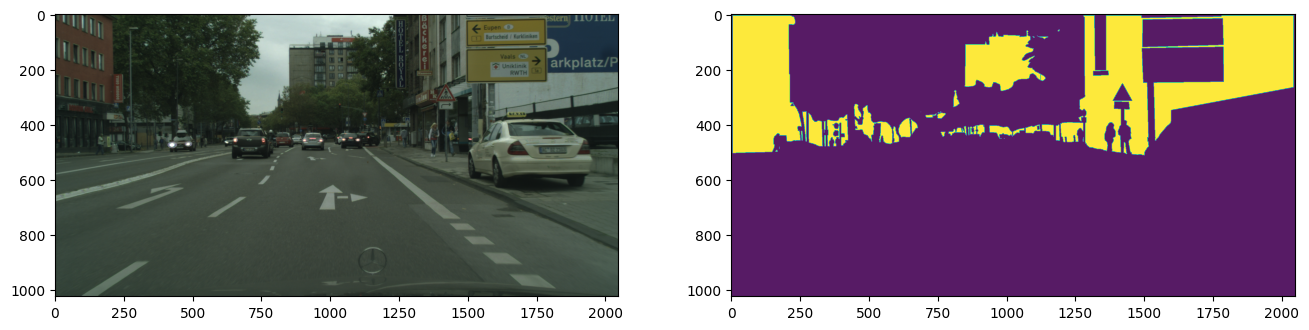

In [ ]:
train_augmentation_maskrcnn = T.Compose([
    T.Resize((512,1024)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    # T.RandomSolarize(threshold=20.0),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    T.ToImage(), T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 
val_augmentation_maskrcnn = T.Compose([
    T.Resize((512,1024)),
    T.ToImage(), T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CityscapesDataset(path_cfg)
img, target = train_dataset[5]
img = np.array(img)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(img.transpose(1, 2, 0))
# print(target["labels"])
plt.subplot(122)
print(target["masks"].shape)
print(target["labels"])
plt.imshow(target["masks"][3], alpha=0.9)

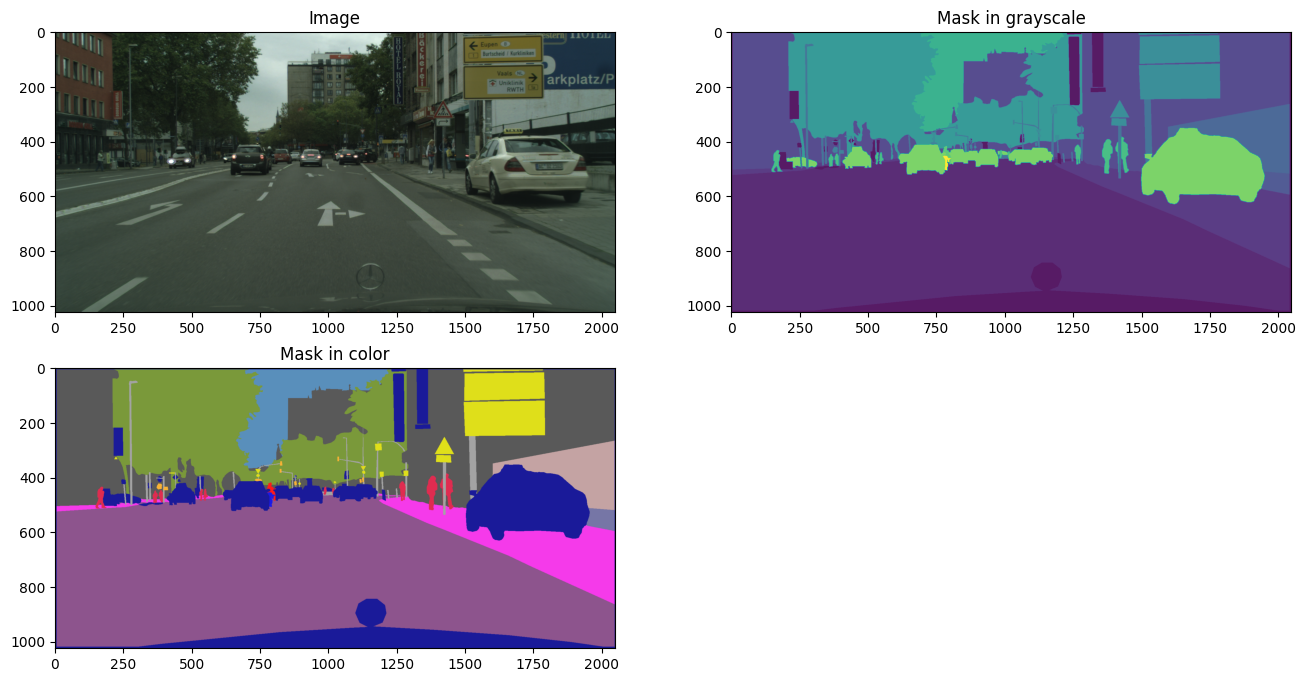

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.title("Image")
plt.imshow(img.transpose(1, 2, 0))
plt.subplot(2, 2, 2)
plt.title("Mask in grayscale")
mask_viz = convert_instance_to_semantic(target['masks'], target['labels'])
plt.imshow(mask_viz, alpha=0.9)
plt.subplot(2, 2, 3)
plt.title("Mask in color")
mask_viz = colorize_mask(mask_viz, class_id_to_color)
plt.imshow(mask_viz.permute(1, 2, 0), alpha=0.9)

In [18]:
def collate_fn(batch):
    """
    Since the number of objects varies per image, we collate the images and targets
    into lists. The model expects a list of images and a list of targets dictionaries.
    """
    # batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    images = [item[0] for item in batch] # This will be a list of image tensors/tv_tensors.Image
    targets = [item[1] for item in batch] # This will be a list of target dictionaries
    return images, targets

def get_dataloader(dataset, config, is_train=True):
    dataloader = DataLoader(dataset, batch_size=(config.per_gpu_train_batch_size if is_train else config.per_gpu_eval_batch_size), num_workers=config.num_workers, shuffle=is_train, collate_fn = collate_fn)
    return dataloader

In [20]:
def show_loss_graph(losses):
    plt.figure(figsize=(12,8))
    plt.title("Loss over training")
    plt.plot(losses, color='b', linewidth=2)
    
    plt.xlabel("steps")
    plt.ylabel("loss value")
    plt.xlim(0, len(losses)-1)
    
    plt.grid()
    plt.legend()
    plt.show()

def show_lr_graph(lrs):
    plt.figure(figsize=(12,8))
    plt.title("Learning rate over training")
    plt.plot(lrs, color='r', linewidth=2)
    
    plt.xlabel("steps")
    plt.ylabel("learning rate")
    plt.xlim(0, len(lrs)-1)
    
    plt.grid()
    plt.legend()
    plt.show()

## Training MaskRCNN

In [ ]:
import random
import colorsys

# Original: https://github.com/matterport/Mask_RCNN
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

# Original: https://github.com/matterport/Mask_RCNN
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c],
                                  image[:, :, c])
    return image

# Original: https://github.com/matterport/Mask_RCNN
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=False,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors if not
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[class_ids[i]]

        # # Bounding box
        # if not np.any(boxes[i]):
        #     # Skip this instance. Has no bbox. Likely lost in image cropping.
        #     continue
        # y1, x1, y2, x2 = boxes[i]
        # if show_bbox:
        #     p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
        #                         alpha=0.7, linestyle="dashed",
        #                         edgecolor=color, facecolor='none')
        #     ax.add_patch(p)

        # # Label
        # if not captions:
        #     class_id = class_ids[i]
        #     score = scores[i] if scores is not None else None
        #     label = class_names[class_id]
        #     caption = "{} {:.3f}".format(label, score) if score else label
        # else:
        #     caption = captions[i]
        # ax.text(x1, y1 + 8, caption,
        #         color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        # padded_mask = np.zeros(
        #     (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        # padded_mask[1:-1, 1:-1] = mask
        # contours = find_contours(padded_mask, 0.5)
        # for verts in contours:
        #     # Subtract the padding and flip (y, x) to (x, y)
        #     verts = np.fliplr(verts) - 1
        #     p = Polygon(verts, facecolor="none", edgecolor=color)
        #     ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956 (from 1)
Receiving objects: 100% (956/956), 137.67 MiB | 47.50 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [ ]:
import torch
from torchvision.transforms import v2 as T
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import random


def visualize_predictions(model, dataset, idx=None, device='cuda', confidence_threshold=0.5):
    """
    Visualizes ground truth, predicted masks, and an overlay of both for a given sample.

    Args:
        model (torch.nn.Module): The trained Mask R-CNN model.
        dataset (Dataset): The Cityscapes dataset instance.
        idx (int, optional): The index of the sample to visualize. If None, a random index is chosen. Defaults to None.
        device (str, optional): The device to run inference on ('cuda' or 'cpu'). Defaults to 'cuda'.
        confidence_threshold (float, optional): The threshold to filter model predictions. Defaults to 0.5.
    """
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    print(f"Visualizing sample at index: {idx}")

    # 1. Get Data and Run Inference
    model.to(device)
    model.eval()

    img, target = dataset[idx]
    
    with torch.no_grad():
        # Add a batch dimension and send to device
        model_input = img.unsqueeze(0).to(device)
        prediction = model(model_input)[0]

    # 2. Prepare Tensors for Visualization (move to CPU and convert to NumPy)
    # Convert image tensor from [C, H, W] to [H, W, C] for plotting
    img = T.Resize((512, 1024))(read_image(dataset.images[idx]))
    img_np = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

    # Ground Truth data
    gt_masks = target['masks'].cpu().numpy()
    gt_labels = target['labels'].cpu().numpy()

    # Prediction data
    pred_scores = prediction['scores'].cpu().numpy()
    high_conf_indices = np.where(pred_scores >= confidence_threshold)[0]

    # Filter predictions based on the confidence threshold
    pred_masks = (prediction['masks'][high_conf_indices] > 0.5).squeeze(1).permute(1, 2, 0).cpu().numpy()
    pred_labels = prediction['labels'][high_conf_indices].cpu().numpy()
    pred_boxes = prediction['boxes'][high_conf_indices].cpu().numpy()

    for i in range(len(pred_boxes)):
        pred_boxes[i][0], pred_boxes[i][1] = pred_boxes[i][1], pred_boxes[i][0] # (y1, x1) instead of (x1, y1)
        pred_boxes[i][2], pred_boxes[i][3] = pred_boxes[i][3], pred_boxes[i][2] # (y2, x2) instead of (x2, y2)
        
    display_instances(img_np, pred_boxes, pred_masks, pred_labels, dataset.class_names)

    plt.tight_layout()
    plt.show()
    model.train()

test_dataset_for_viz = CityscapesDataset(path_cfg, val_augmentation_maskrcnn, split='train')

2025-09-27 09:39:58.293119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758965998.475009      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758965998.529435      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Initialized Cityscapes dataset for 'semantic' task.
Found 2975 samples in split 'train'.
torch.Size([35, 3])


In [ ]:
def train_semantic(model, train_dataset, config):
    n_total = len(train_dataset) * config.n_epochs
    model.to(config.device)
    model.train()
    train_dataloader = get_dataloader(train_dataset, config)
    optimizer = optim.AdamW(model.parameters(), lr=config.optimizer.params.lr, eps=config.optimizer.params.eps, weight_decay=config.optimizer.params.weight_decay)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.99, patience=5, cooldown=3, min_lr=1e-5)

    # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_total, eta_min=1e-6)

    scaler = None
    if config.scaler:
        scaler = torch.amp.GradScaler(config.device, enabled=True)
    step_losses = []
    lrs = []
    with tqdm(total=n_total, unit="step") as pbar:
        for epoch in range(1, config.n_epochs+1):
            epoch_loss = 0.0
            for batch in train_dataloader:
                images, targets = batch
                
                images = [image.to(config.device) for image in images]
                targets = [{k: v.to(config.device) for k, v in t.items()} for t in targets]
                with torch.amp.autocast(device_type=config.device, enabled=(scaler is not None)):
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())

                loss_value = losses
        
                optimizer.zero_grad()
                if scaler is not None:
                    scaler.scale(loss_value).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss_value.backward()
                    optimizer.step()
                    
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler_metric = loss_value.item()
                    scheduler.step(scheduler_metric)
                else:
                    scheduler.step()

                
                step_losses.append(loss_value.item())
                lrs.append(scheduler.get_last_lr()[0])
                epoch_loss += loss_value.item()
                pbar.update(len(images))
                pbar.set_postfix(
                    current_loss=f"{loss_value.item():.4f}",
                    avg_loss=f"{sum(step_losses)/len(step_losses):.4f}", 
                    lr=f"{scheduler.get_last_lr()[0]:.1e}"
                )
                
            # visualize here
            epoch_loss /= len(train_dataloader)
            print(f"Epoch {epoch}/{config.n_epochs+1} average loss: {epoch_loss}")
            visualize_predictions(model, test_dataset_for_viz, idx=2, device='cuda', confidence_threshold=0.5)

    torch.save({
        'epoch': config.n_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'step_losses': step_losses,
    }, "/kaggle/working/MaskRCNN_dice_ckpt10epoch.pth")

    show_loss_graph(step_losses)
    show_lr_graph(lrs)
    return model, step_losses

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 185MB/s]


Visualizing sample at index: 2

*** No instances to display *** 



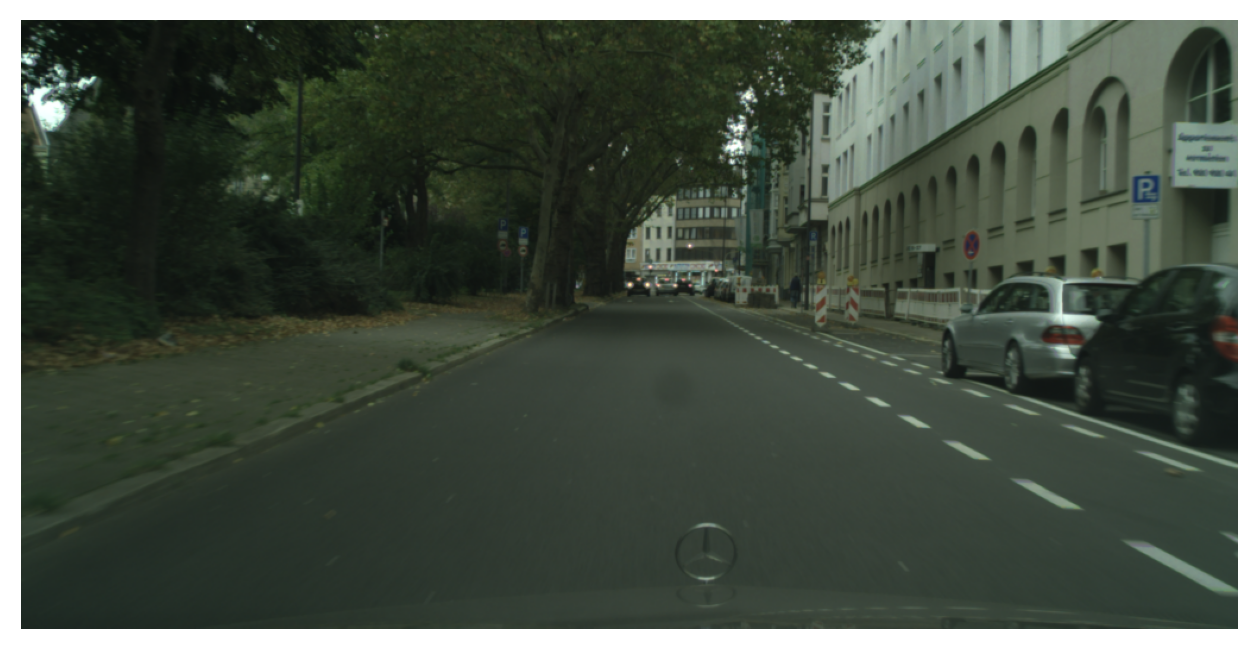

<Figure size 640x480 with 0 Axes>

Initialized Cityscapes dataset for 'semantic' task.
Found 2975 samples in split 'train'.


In [24]:
config['device'] = 'cuda' if torch.cuda.is_available() else "cpu"
config['scaler'] = 'amp'
config['per_gpu_train_batch_size'] = 6 # if 1 gpu -> dont have to be power of 2
config['n_epochs'] = 5
config.optimizer.params.lr = 3e-4
model = build_model(model_cfg, 3, 20)
visualize_predictions(model, test_dataset_for_viz, idx=2, device='cuda', confidence_threshold=0.5)
train_dataset = CityscapesDataset(path_cfg, train_augmentation_maskrcnn)

 20%|██        | 2975/14875 [23:23<1:04:47,  3.06step/s, avg_loss=1.3468, current_loss=1.2046, lr=1.8e-04]

Epoch 1/6 average loss: 1.3467705785747497
Visualizing sample at index: 2


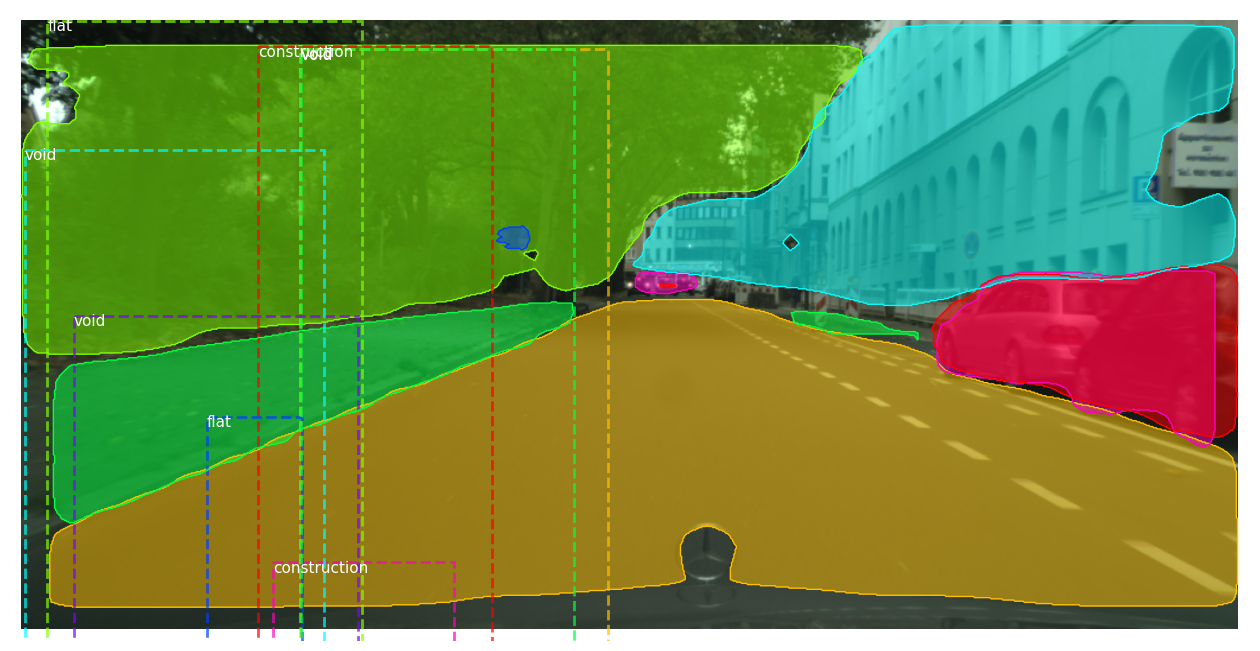

<Figure size 640x480 with 0 Axes>

 40%|████      | 5950/14875 [46:00<42:57,  3.46step/s, avg_loss=1.2651, current_loss=1.0335, lr=1.0e-04]

Epoch 2/6 average loss: 1.1833702115522278
Visualizing sample at index: 2


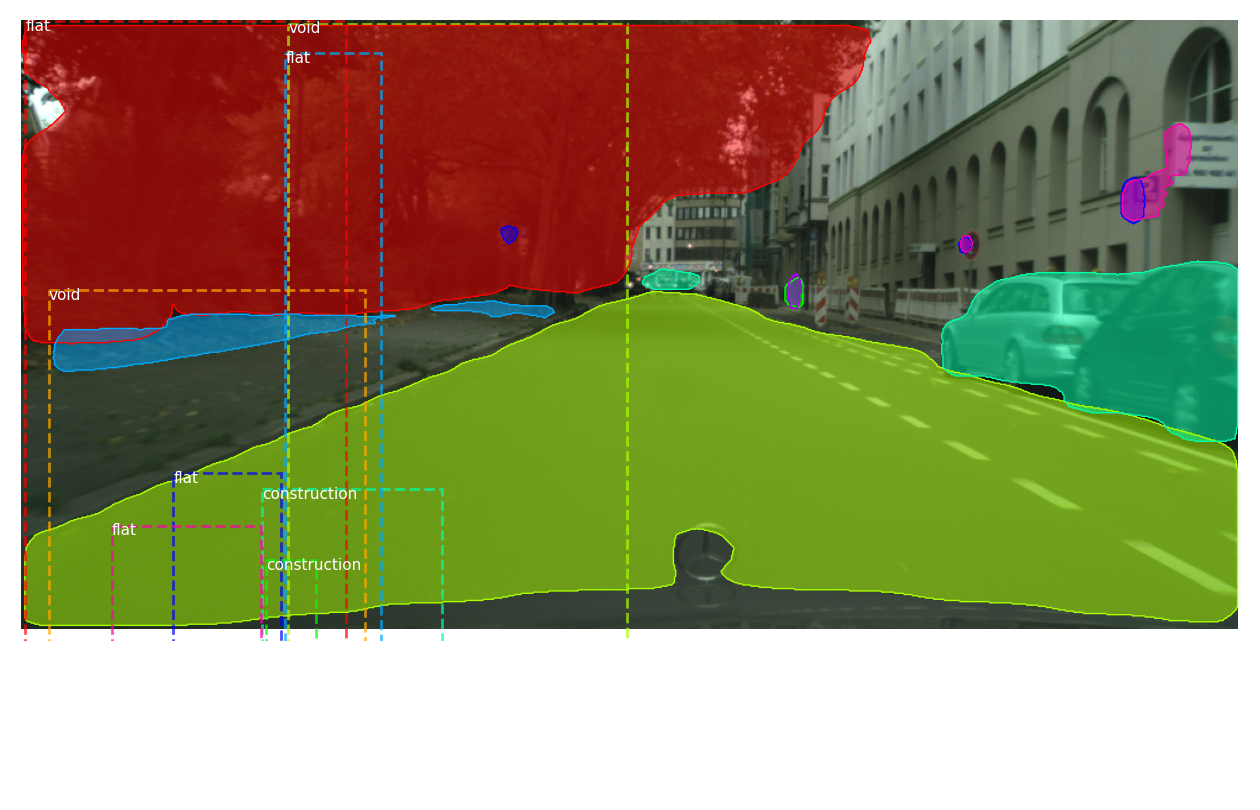

<Figure size 640x480 with 0 Axes>

 60%|██████    | 8925/14875 [1:09:18<30:24,  3.26step/s, avg_loss=1.2209, current_loss=1.1274, lr=6.1e-05]

Epoch 3/6 average loss: 1.1324485643736777
Visualizing sample at index: 2


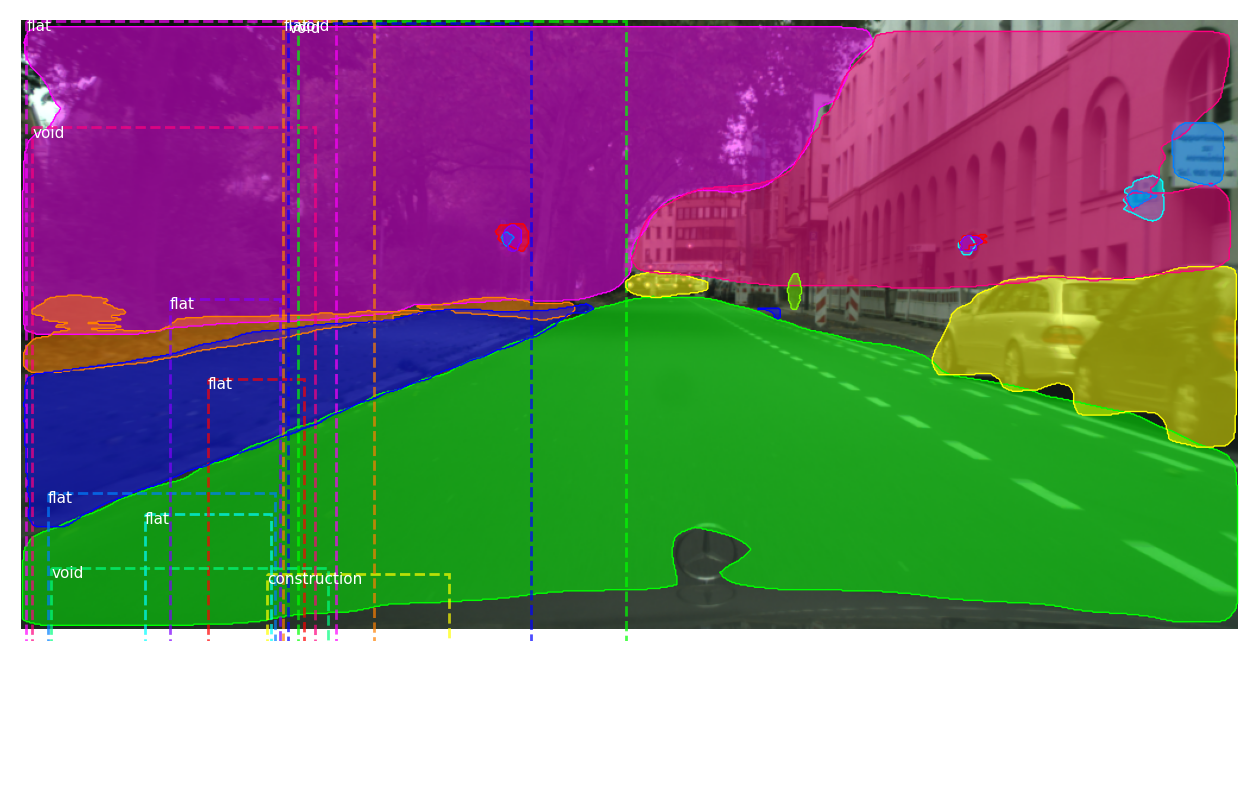

<Figure size 640x480 with 0 Axes>

 80%|████████  | 11900/14875 [1:31:33<14:21,  3.46step/s, avg_loss=1.1896, current_loss=1.0494, lr=3.5e-05]

Epoch 4/6 average loss: 1.0959119120192142
Visualizing sample at index: 2


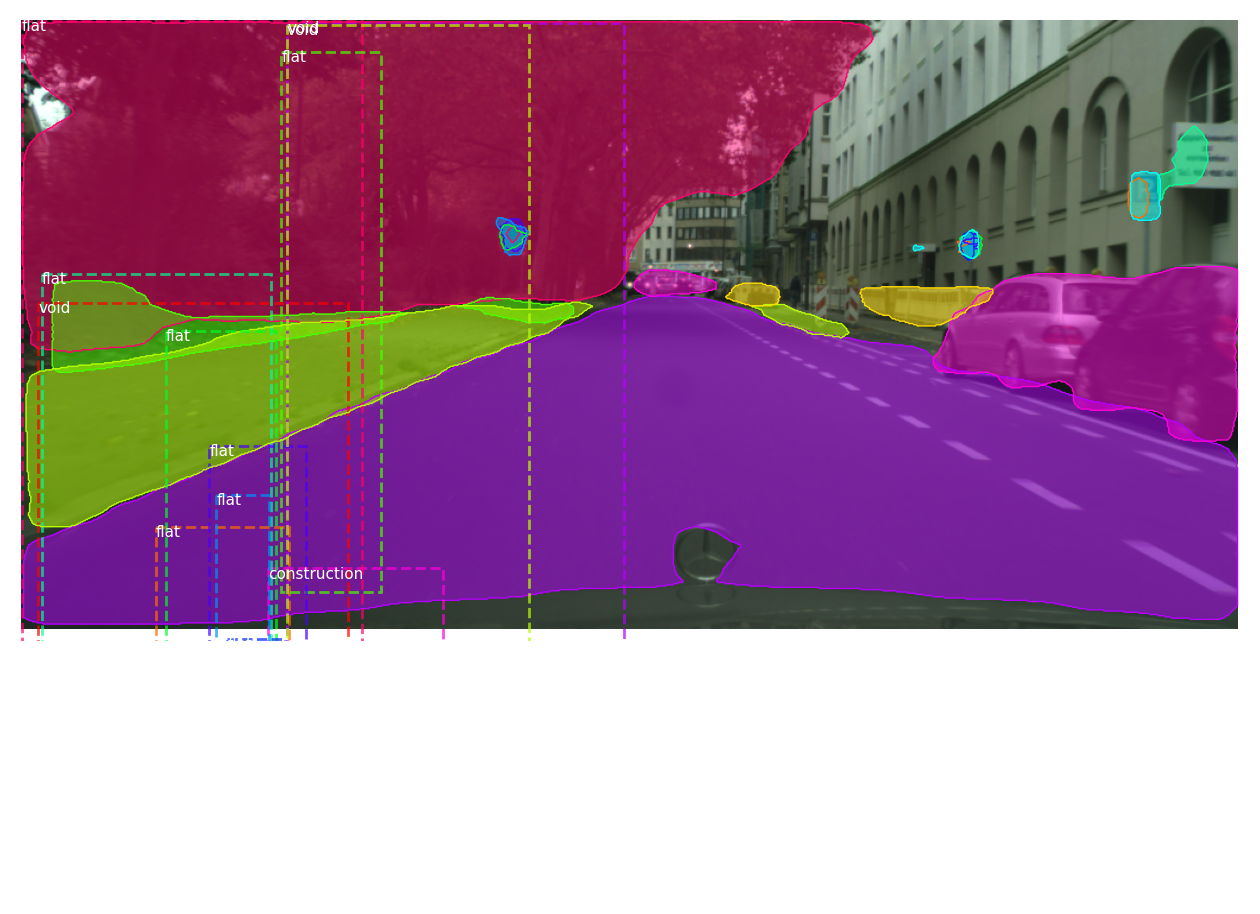

<Figure size 640x480 with 0 Axes>

100%|██████████| 14875/14875 [1:54:39<00:00,  3.35step/s, avg_loss=1.1660, current_loss=1.0116, lr=2.0e-05]

Epoch 5/6 average loss: 1.0715322986004814
Visualizing sample at index: 2


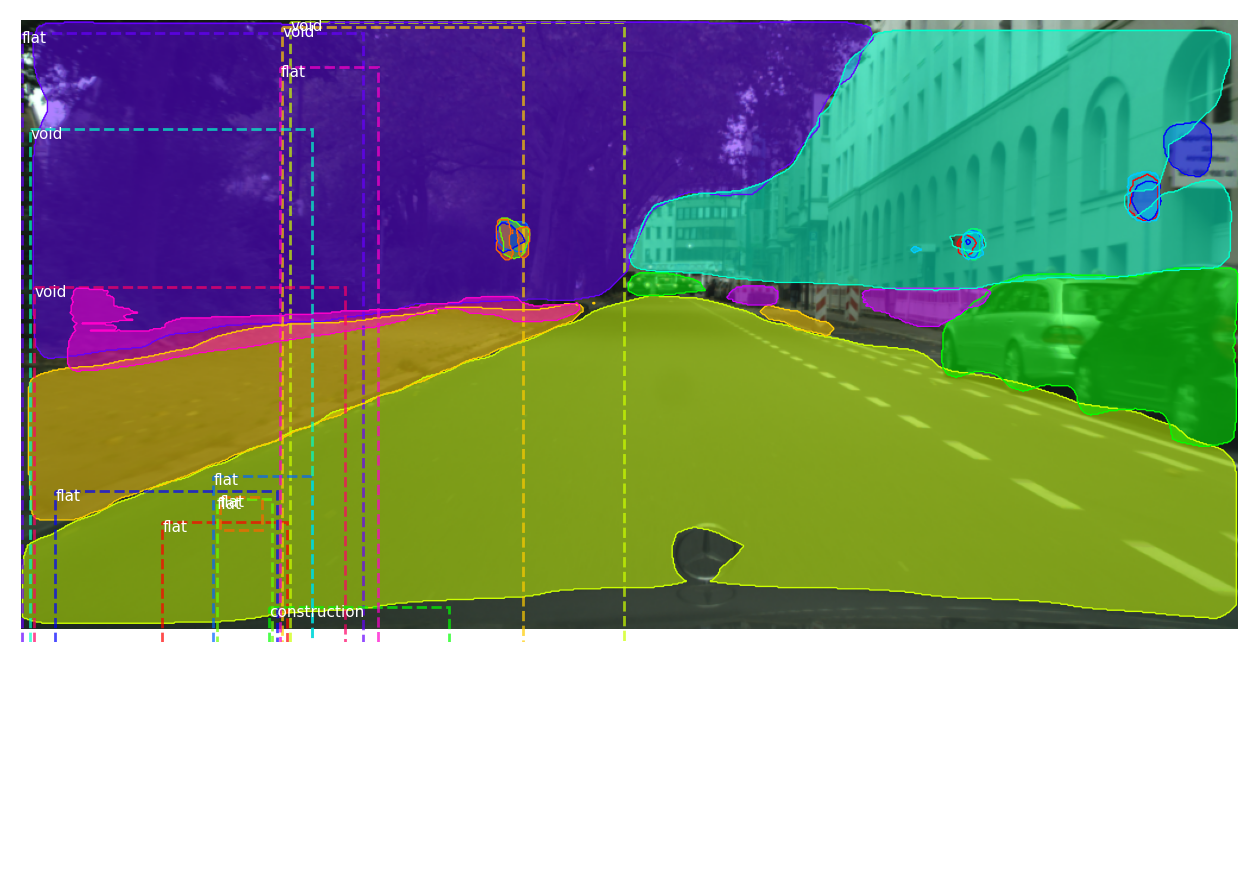

<Figure size 640x480 with 0 Axes>

100%|██████████| 14875/14875 [1:54:42<00:00,  2.16step/s, avg_loss=1.1660, current_loss=1.0116, lr=2.0e-05]


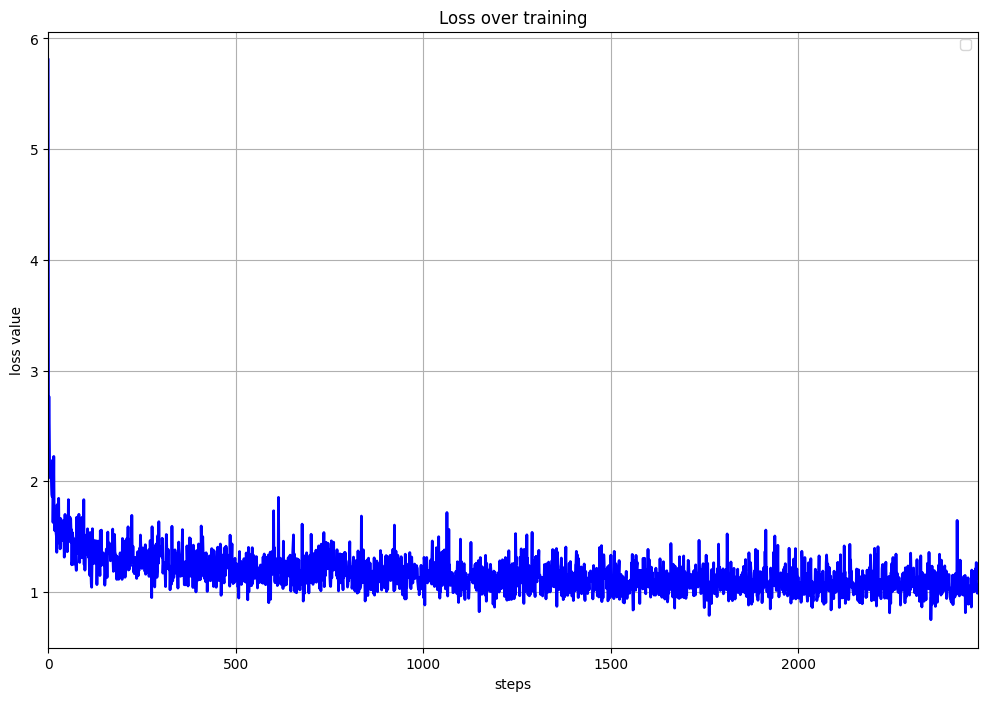

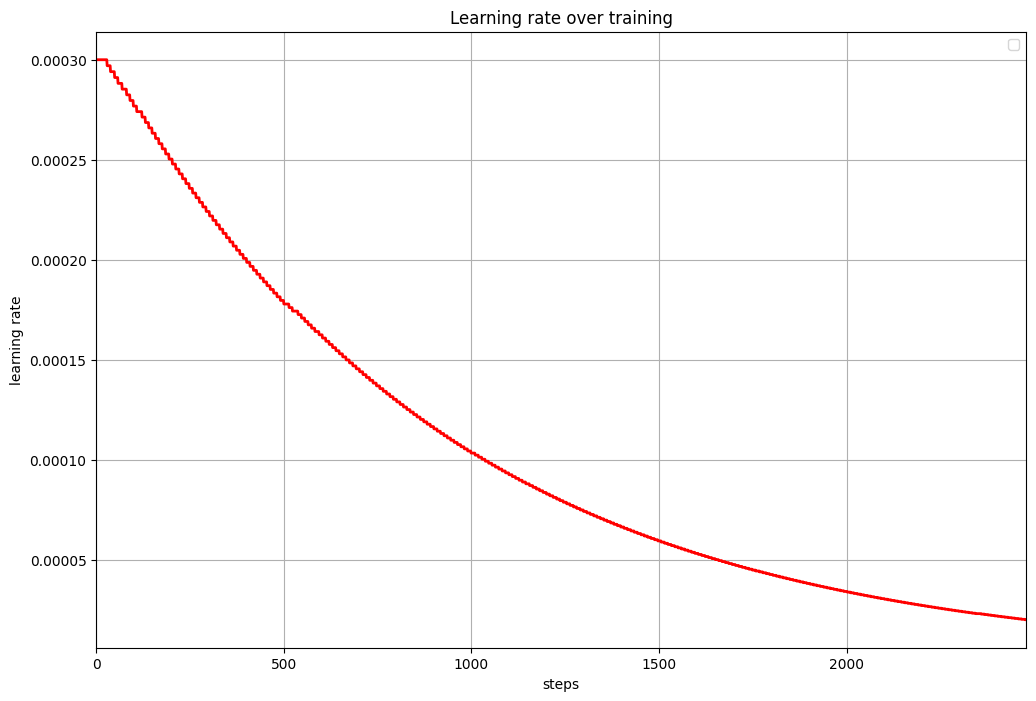

In [25]:
maskrcnn_model, step_losses = train_semantic(model, train_dataset, config)

In [26]:
# torch.save({
#     'epoch': config.n_epochs,
#     'model_state_dict': maskrcnn_model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'step_losses': step_losses,
# }, "/kaggle/working/MaskRCNN_ckpt3epoch.pth")

# Validation

In [ ]:
from torchmetrics.segmentation import MeanIoU

model_cfg.model_name = 'MaskRCNN'
maskrcnn_model = build_model(model_cfg, 3, 20)

weights_dict = torch.load("/kaggle/input/segmentation_cityscapes/pytorch/v01/6/MaskRCNN_20c_ckpt5epoch.pth", map_location=config.device)
maskrcnn_model.load_state_dict(weights_dict["model_state_dict"])
maskrcnn_model.to(config.device)
print("Load maskrcnn complete!")

Load maskrcnn complete!


In [ ]:
def evaluate_maskrcnn_model(model, dataloader, device, num_classes):
    """
    Evaluates a Mask R-CNN model on a derived SEMANTIC task using MeanIoU.
    This is a non-standard evaluation for Mask R-CNN but useful for comparison.
    It correctly ignores the class index 255.
    """
    print('Evaluating Mask R-CNN for Semantic mIoU...')
    model.eval()
    
    metric = MeanIoU(num_classes=20, include_background=False)
    dl = 0.0
    cnt = 0
    with torch.no_grad():
        with tqdm(total=len(dataloader), leave=False) as pbar:
            for images, targets in dataloader:
                images = list(image.to(device) for image in images)
                cnt += len(images)
                
                predictions = model(images)

                pred_masks_batch = []
                gt_masks_batch = []

                for i in range(len(images)):
                    img_height, img_width = images[i].shape[-2:]
                    
                    # ------------------------------------------------ prediction ---------------------------------------------------------
                    predicted_class_map = torch.full(
                        (img_height, img_width),
                        fill_value=0, 
                        dtype=torch.long,
                        device=device
                    )

                    image_predictions = predictions[i]
                    pred_masks_i = image_predictions['masks'].clone()   # (N_pred, 1, H, W)
                    pred_labels_i = image_predictions['labels'].clone() # (N_pred)
                    pred_scores_i = image_predictions['scores'].clone() # (N_pred)

                    if pred_masks_i.numel() > 0:
                        pred_masks_i = pred_masks_i.squeeze(1)

                        # Sort predictions by score in ascending order
                        sorted_indices = torch.argsort(pred_scores_i, descending=False)
                        pred_masks_i = pred_masks_i[sorted_indices]
                        pred_labels_i = pred_labels_i[sorted_indices]

                        for j in range(pred_masks_i.shape[0]):
                            mask_j = (pred_masks_i[j] > 0.5)
                            label_j = pred_labels_i[j]

                            if label_j < num_classes:
                                predicted_class_map[mask_j] = label_j # gradually replaced by class with higher score
                                
                    pred_masks_batch.append(predicted_class_map)

                    # ------------------------------------------------ Ground truth ---------------------------------------------------------
                    ground_truth_semantic_map = torch.full(
                        (img_height, img_width),
                        fill_value=0,
                        dtype=torch.long,
                        device=device
                    )

                    image_targets = targets[i]
                    gt_masks_i = image_targets['masks'].clone()   # (N_gt, H, W) (0 or 1)
                    gt_labels_i = image_targets['labels'].clone() # (N_gt)

                    if gt_masks_i.numel() > 0:
                        for j in range(gt_masks_i.shape[0]):
                            mask_j = (gt_masks_i[j] == 1)
                            label_j = gt_labels_i[j]

                            if label_j < num_classes:
                                ground_truth_semantic_map[mask_j] = label_j

                    gt_masks_batch.append(ground_truth_semantic_map)

                pred_masks_batch = torch.stack(pred_masks_batch).cpu()
                gt_masks_batch = torch.stack(gt_masks_batch).cpu()
                if len(pred_masks_batch) > 0 and len(gt_masks_batch) > 0:
                    metric.update(pred_masks_batch, gt_masks_batch)

                # pred_logits_batch = torch.zeros(
                #     (pred_masks_batch.shape[0], num_classes-1, img_height, img_width),
                #     dtype=torch.float,
                #     device='cpu'
                # )
                # for i in range(pred_masks_batch.shape[0]):
                #     predicted_class_map = pred_masks_batch[i]
                #     valid_pixels_mask = (predicted_class_map != 0)
                #     if valid_pixels_mask.any():
                #         for c in range(num_classes-1):
                #             pred_logits_batch[i, c, valid_pixels_mask] = ((predicted_class_map[valid_pixels_mask] == c+1).float() * 1.0)

                # # [B, 19, H, W]: 0..18 class represent 1..19 in training (define 0 is the unlabel, which must be ignore)
                # manual_target_one_hot = torch.zeros((gt_masks_batch.shape[0], 19, gt_masks_batch.shape[1], gt_masks_batch.shape[2]), dtype=torch.long)
                # for i in range(gt_masks_batch.shape[0]):
                #     unique_classes_in_this_mask = torch.unique(gt_masks_batch[i])
                #     for class_id in range(num_classes-1): # 0...19 -> 1..19
                #         if class_id in unique_classes_in_this_mask:
                #             manual_target_one_hot[i, class_id, :, :] = (gt_masks_batch[i] == class_id+1).long()

                # dl += dice_loss(pred_logits_batch, manual_target_one_hot, multiclass=True)
                pbar.update(1)
                pbar.set_postfix(iou=f"{metric.compute():.4f}", dl=f"{(dl/cnt):.4f}")
                # if cnt >= 5:
                #     break

    val_miou = metric.compute()
    print(val_miou)
    model.train()
    return val_miou

In [41]:
from torchmetrics.segmentation import MeanIoU
from torchmetrics.detection import MeanAveragePrecision

val_dataset = CityscapesDataset(path_cfg, val_augmentation_maskrcnn, split='val')
config['per_gpu_eval_batch_size'] = 4
val_dataloader = get_dataloader(val_dataset, config, is_train=False)
# metric = MeanIoU(num_classes=20).to(config.device)
MasRCNN_val_miou = evaluate_maskrcnn_model(maskrcnn_model, val_dataloader, config.device, 20)
print(MasRCNN_val_miou)

Initialized Cityscapes dataset for 'semantic' task.
Found 500 samples in split 'val'.
Evaluating Mask R-CNN for Semantic mIoU...


tensor(0.8093)
(tensor(0.8093), tensor(0.2234))


In [ ]:
import torch
from torchvision.transforms import v2 as T
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_predictions(model, dataset, idx=None, device='cuda', confidence_threshold=0.5):
    """
    Visualizes ground truth, predicted masks, and an overlay of both for a given sample.

    Args:
        model (torch.nn.Module): The trained Mask R-CNN model.
        dataset (Dataset): The Cityscapes dataset instance.
        idx (int, optional): The index of the sample to visualize. If None, a random index is chosen. Defaults to None.
        device (str, optional): The device to run inference on ('cuda' or 'cpu'). Defaults to 'cuda'.
        confidence_threshold (float, optional): The threshold to filter model predictions. Defaults to 0.5.
    """
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    print(f"Visualizing sample at index: {idx}")

    # 1. Get Data and Run Inference
    model.to(device)
    model.eval()

    img, target = dataset[idx]
    
    with torch.no_grad():
        # Add a batch dimension and send to device
        model_input = img.unsqueeze(0).to(device)
        prediction = model(model_input)[0]

    # 2. Prepare Tensors for Visualization (move to CPU and convert to NumPy)
    # Convert image tensor from [C, H, W] to [H, W, C] for plotting
    img = T.Resize((512, 1024))(read_image(dataset.images[idx]))
    img_np = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

    # Ground Truth data
    gt_masks = target['masks'].cpu().numpy()
    gt_labels = target['labels'].cpu().numpy()

    # Prediction data
    pred_scores = prediction['scores'].cpu().numpy()
    high_conf_indices = np.where(pred_scores >= confidence_threshold)[0]

    # Filter predictions based on the confidence threshold
    pred_masks = (prediction['masks'][high_conf_indices] > 0.5).squeeze(1).permute(1, 2, 0).cpu().numpy()
    pred_labels = prediction['labels'][high_conf_indices].cpu().numpy()
    pred_boxes = prediction['boxes'][high_conf_indices].cpu().numpy()

    plt.figure(figsize=(16,8))
    plt.subplot(121)
    mask_viz = convert_instance_to_semantic(target['masks'], target['labels'])
    plt.imshow(mask_viz)
    plt.subplot(122)
    display_instances(img_np, pred_boxes, pred_masks, pred_labels, dataset.class_names)

    plt.tight_layout()
    plt.show()

test_dataset_for_viz = CityscapesDataset(path_cfg, val_augmentation_maskrcnn, split='train')
visualize_predictions(maskrcnn_model, test_dataset_for_viz, device='cuda', confidence_threshold=0.7)